#### Notebook for running X-CER experiments on TrueQ Simulators

##### **Things to Check and Remember Before Running This Notebook**

1. Do not use this notebook for analysis or for loading in circuits
2. Ensure all imports (`xcer_funcs` especially) are imported
3. Save circuits before, during, and after execution
4. Do not use `trueq.Executor.block()`

In [71]:
##### Imports #####
# xcer_funcs contains functions for generating the X-CER circuits
# We also want to import the Qiskit IBM Provider
from xcer_funcs import *
from datalogger import DataLogger

from qiskit_ibm_provider import IBMProvider

# Import numpy and trueq
import numpy as np
import trueq as tq

import datetime
import random

In [126]:
# Generate a unique identifer for bookeeping purposes
id = str(random.randint(0, 1000000))
print(F"ID for these simulations: {id}")

date_str = datetime.datetime.now().strftime("%Y%m%d")

results_directory = F"../simulations/{date_str}/{id}/"

dl = DataLogger(directory=results_directory, id=id)

experiments_info = {"id": id, 
                    "date": datetime.datetime.now().strftime("%Y-%m-%d")}

ID for these simulations: 417855


In [127]:
# Define the parameters for the experiment

# Using sequence lengths of 4, 8, 12 for coherent errors and cnot repetitions 4, 8, 12
rep_len_tuples = [(4, 4), (8, 4), (12, 4), (4, 8), (8, 8), (12, 8), (4, 12),
                  (8, 12), (12, 12), (1, 32), (3, 32), (5, 32), (1, 64), (3, 64), (5, 64)]

# Define the hard cycle of interest
# the cycle is a CNOT on qubits 0,1 and an identity gate on ancillary qubit 2
cycle = tq.Cycle({(0, 1): tq.Gate.cx, 2: tq.Gate.id})

# Generate the CER circuits
# pass in the cycle, repetitions, and sequence_lengths
cer_circuits = generate_cer_circuits(cycle, rep_len_tuples, n_circuits=450)

# We can change the batch size here
batch_size = 300
num_batches = int(np.ceil(len(cer_circuits) / batch_size))
print(f"Number of batches: {num_batches}")
print(F"Total number of CER circuits: {len(cer_circuits)}")

# Draw our hard cycle of interest
print("Hard cycle of interest:")
cycle_circ = tq.Circuit(cycles=[cycle])
cycle_circ.draw()

# Gather circuit info, save circuits to disk
experiments_info['batch_size'] = batch_size
experiments_info['num_batches'] = num_batches
experiments_info['num_circuits'] = len(cer_circuits)
experiments_info['rep_len_tuples'] = rep_len_tuples

# Save circuits before execution
cer_circuits.save(f"../simulations/{date_str}/{id}/unexecuted_cer_circuits.tq", overwrite=True)

dl.write_data(experiments_info)

Number of batches: 68
Total number of CER circuits: 20250
Hard cycle of interest:


In [128]:
dl.read_data()

{'id': '417855',
 'date': '2024-01-18',
 'batch_size': '300',
 'num_batches': '68',
 'num_circuits': '20250',
 'rep_len_tuples': '[(4, 4), (8, 4), (12, 4), (4, 8), (8, 8), (12, 8), (4, 12), (8, 12), (12, 12), (1, 32), (3, 32), (5, 32), (1, 64), (3, 64), (5, 64)]'}

Coherent contribution to the Z error rate: 0.001, initial angle: 3.623703271523066 degrees
len(hamiltonian)= 68
Length of simulator list: 68
Length of angle list: 68
Average angle (Z): 3.597411578937451
Average Z rate: 0.0009929557689342889
Num Batched: 68


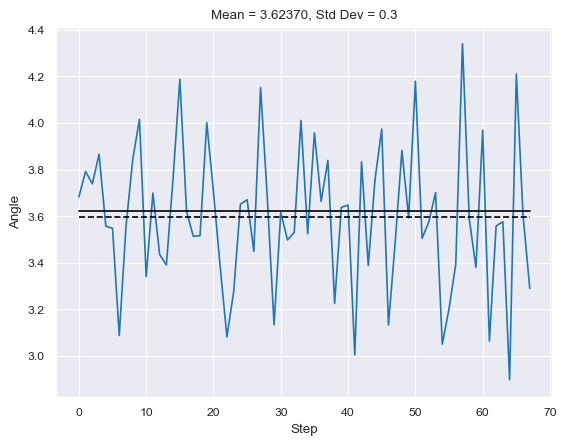

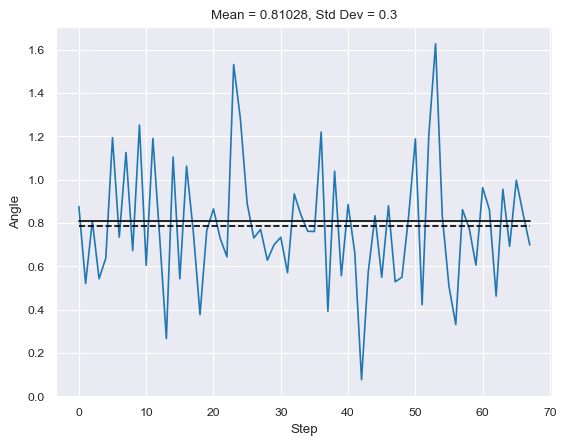

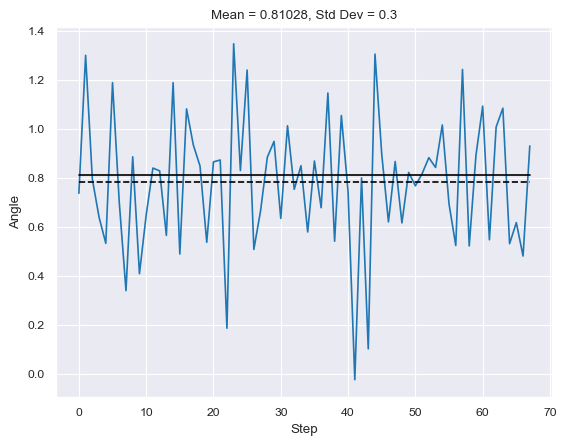

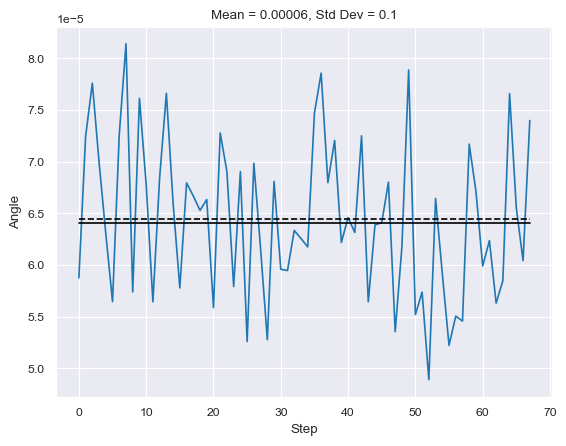

In [129]:
# ===================   IBM Error Parameters ===============================
# obtained from looking at median values on ibm_sherbrooke (127-qubits, 32 QV, 904 CLOPS)
# Recorded on 8/2/2023
# t1 = 282e-6  # T1 relaxation time
# t2 = 171e-6  # T2 dephasing time
# t_single = 35e-9  # single qubit gate time (DOUBLE CHECK)
# t_entangling = 533e-9  # entangling (CNOT) gate time


# ibm_cairo error rates
t1 = 6.182532376672508e-05
t2 = 6.405694213764325e-05
t_single = 3.5555555555555554e-08
t_entangling = 4.053333333333333e-07

# put these in a dictionary for easy access
# error_rates = {
#     "t1": t1,
#     "t2": t2,
#     "t_single": t_single,
#     "t_entangling": t_entangling,
# }
error_rates = [{"t1": t1, "t2": ttwo, "t_single": t_single, "t_entangling": t_entangling} for ttwo in generate_t2_values(t2, num_batches, 0.1)]

t2_list = [erate["t2"] for erate in error_rates]
# error_rates = {"t2": ttwo for ttwo in generate_t2_values(t2, num_batches, 0.001)}
# error_rates["t1"] = t1
# error_rates["t_single"] = t_single
# error_rates["t_entangling"] = t_entangling
# ===========================================================================

# Use the gaussian_random_walk function to generate a list of angles using an initial angle
# the initial angle will be calculated from the coherent_z_error_rate, representing the coherent contribution to the Z error rate

# Calculate the initial angle from the coherent contribution to the Z error rate
coherent_z_error_rate = 0.001
coherent_x_error_rate = 0.00005
coherent_y_error_rate = 0.00005

initial_z_angle = np.sqrt(coherent_z_error_rate) * 180/np.pi*2
initial_x_angle = np.sqrt(coherent_x_error_rate) * 180/np.pi*2
initial_y_angle = np.sqrt(coherent_y_error_rate) * 180/np.pi*2


print(
    F"Coherent contribution to the Z error rate: {coherent_z_error_rate}, initial angle: {initial_z_angle} degrees")

# Define step size and standard deviation
std_dev = 0.3

# Define important parameters such as the ancilla index:
ancilla_index = 2
qubit_index = 2

# Generate list of angles
# angle_list = gaussian_random_walk(
#     initial_angle=initial_angle, num_steps=num_batches, step_size=step_size, std_dev=std_dev)

zangle_list = sample_gaussian(initial_angle=initial_z_angle, num_steps=num_batches, std_dev=std_dev)
xangle_list = sample_gaussian(initial_angle=initial_x_angle, num_steps=num_batches, std_dev=std_dev)
yangle_list = sample_gaussian(initial_angle=initial_y_angle, num_steps=num_batches, std_dev=std_dev)

# Shuffle the list of angles
# np.random.shuffle(angle_list)

# Generate list of ancilla hamiltonians
hamiltonian_list = [generate_hamiltonian(zangle=zangle, yangle=yangle, xangle=xangle) for zangle, xangle, yangle in zip(zangle_list, xangle_list, yangle_list)]
# hamiltonian_list = [generate_hamiltonian(zangle=zangle, yangle=yangle) for zangle, yangle in zip(zangle_list, yangle_list)]
# hamiltonian_list = [generate_hamiltonian(zangle=zangle, xangle=xangle) for zangle, xangle in zip(zangle_list, xangle_list)]
# hamiltonian_list = [generate_hamiltonian(zangle=zangle) for zangle in zangle_list]
# Generate a list of simulators
simulator_list = [generate_simulator(basic_error_rates=erate, ancilla_hamiltonian=hamiltonian,
                                     ancilla_index=ancilla_index, cycle=cycle) for hamiltonian, erate in zip(hamiltonian_list, error_rates)]

print("len(hamiltonian)=", len(hamiltonian_list))

print(f"Length of simulator list: {len(simulator_list)}")
print(f"Length of angle list: {len(zangle_list)}")
print(f"Average angle (Z): {np.mean(zangle_list)}")
print(
    f"Average Z rate: {np.mean([angle_to_rate(angle) for angle in zangle_list])}")
print(f"Num Batched: {num_batches}")

avg_z_error_rate = np.mean([angle_to_rate(angle) for angle in zangle_list])
avg_x_error_rate = np.sqrt([angle_to_rate(angle) for angle in xangle_list])
avg_y_error_rate = np.sqrt([angle_to_rate(angle) for angle in yangle_list])

avg_error_rate_dict = {"X": avg_x_error_rate,
                       "Y": avg_y_error_rate, "Z": avg_z_error_rate}

plot_angle_walk(zangle_list, initial_z_angle, num_batches, std_dev)
plot_angle_walk(xangle_list, initial_x_angle, num_batches, std_dev)
plot_angle_walk(yangle_list, initial_y_angle, num_batches, std_dev)

plot_angle_walk(t2_list, t2, num_batches, 0.1)

experiments_info["xangle_list"] = list(xangle_list)
experiments_info["zangle_list"] = list(zangle_list)
experiments_info["yangle_list"] = list(yangle_list)

experiments_info["initial_z_rate"] = coherent_z_error_rate
experiments_info["initial_x_rate"] = coherent_x_error_rate
experiments_info["initial_y_rate"] = coherent_y_error_rate


dl.write_data(experiments_info)

In [130]:
batched_circuits = batch_circuits(cer_circuits, batch_size=batch_size)

Number of batches: 68
Length of first batch: 300
length of final batch: 150


In [131]:
# # run the batches on the simulators
from time import sleep
for batch, simulator in zip(batched_circuits, simulator_list):
    simulator.run(batch, n_shots=10000, overwrite=True)
    sleep(1)

In [ ]:
cer_circuits.save(F"../simulations/{date_str}/{id}/executed_circuits.tq", overwrite=True)

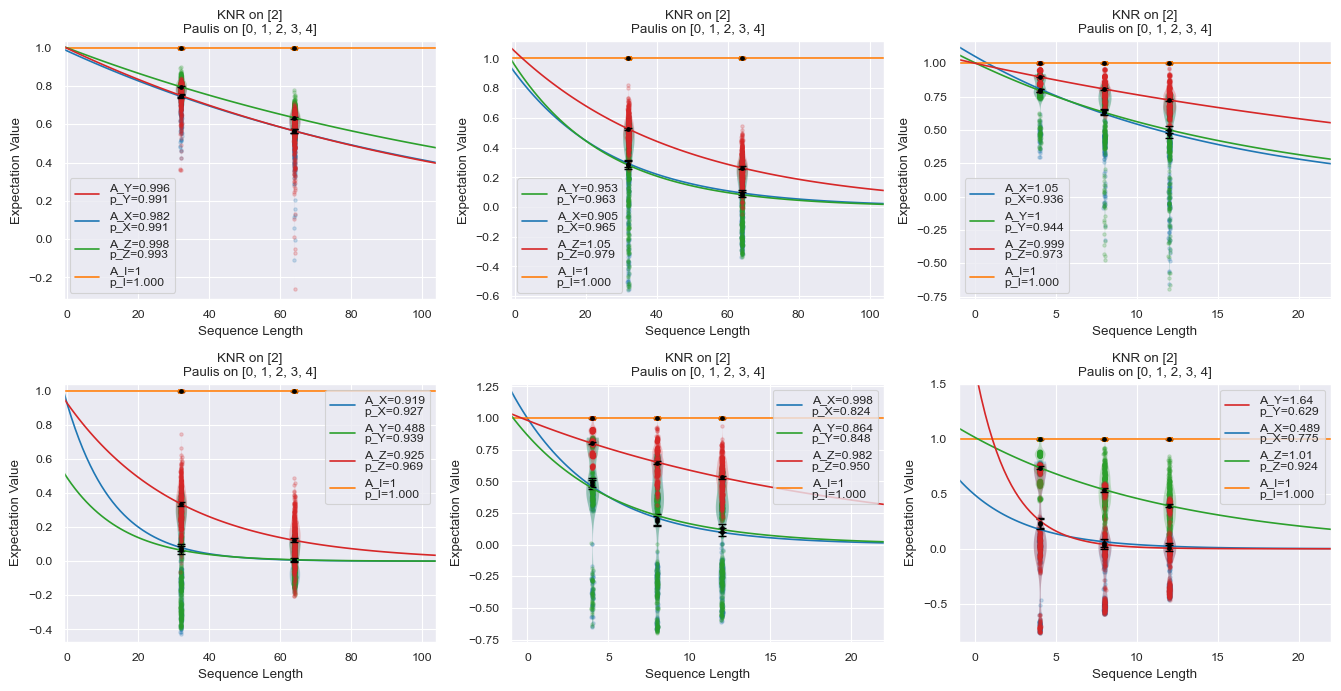

In [96]:
# plot all decays on two axes in a particular order
cer_circuits.plot.raw(labels=(ancilla_index,))

In [39]:
dl.read_data()

{'id': '177529',
 'date': '2024-01-15',
 'batch_size': '300',
 'num_batches': '68',
 'num_circuits': '20250',
 'rep_len_tuples': '[(4, 4), (8, 4), (12, 4), (4, 8), (8, 8), (12, 8), (4, 12), (8, 12), (12, 12), (1, 32), (3, 32), (5, 32), (1, 64), (3, 64), (5, 64)]',
 'xangle_list': '[-1.4456475255590446, -0.5536435727923572, 0.20809185978373038, -0.4380840372561913, -0.2303944772654956, 0.10820537495327698, 0.40430536261552835, -0.022055084980627956, -0.503706073148868, 0.018108951766230404, 0.39113064216021093, 0.1171874181901808, 0.26093407973408306, 0.08123586127062138, -0.3583336963032087, 0.5113957793956965, 0.4953487444632623, -0.23042256355847948, 0.34186463234023223, -0.37310482121731564, 0.1971662444505711, -0.1145036260636133, -0.12797412041270725, -0.40440806665118895, -0.2615362450884057, 0.17853220293400432, -0.3049554318495913, -0.1245885492969377, 0.05152590589848719, -0.2593168037868684, -0.11348746391261166, -0.03914136258658114, -0.09661429211764518, -0.7365432367247243